In [104]:
#IMPORTS

In [105]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

DATA LOADING 

In [106]:
df = pd.read_csv("cleaned_train_data_final.csv")


if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

df.head()
print("the average delay (in min)",df["Arrival_Delay_min"].mean())

the average delay (in min) 35.119465456379224


In [107]:
# 1 = delayed, 0 = on-time
df["Delay_Class"] = (df["Arrival_Delay_min"] > 15).astype(int)
df["Speed_reduced"]=(df["est_avg_speed"]>(df["actual_avg_speed"]+1)).astype(int)
print(df["arrival_diff_min"].mean())

35.119465456379224


In [108]:
features = [
    'Distance_km','Scheduled_Travel_Time_min','Day_of_Week','Month',
    'Is_Holiday','Festive_Period','Temperature_C','Humidity_pct',
    'Precipitation_mm','WindSpeed_kmph','Visibility_km','Pressure_hPa',
    'Track_Maintenance','Signal_Failure','Engine_Breakdown',
    'Previous_Train_Delay_min','Number_of_Stops','Crew_Change',
    'Passenger_Load_pct'
]

X = df[features]
y = df["Delay_Class"]
z = df["Speed_reduced"]


TRAIN TEST AND SPLIT

In [109]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,  test_size=0.2, random_state=42
)

In [ ]:

for df_ in [X_train, X_test]:
    df_["Humidity_pct"] = pd.to_numeric(df_["Humidity_pct"], errors="coerce")


cat_cols = X_train.select_dtypes(include='object').columns.drop("Humidity_pct", errors="ignore")
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    le_dict[col] = le

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [111]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9208270297528997

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       314
           1       0.92      1.00      0.96      3652

    accuracy                           0.92      3966
   macro avg       0.46      0.50      0.48      3966
weighted avg       0.85      0.92      0.88      3966



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

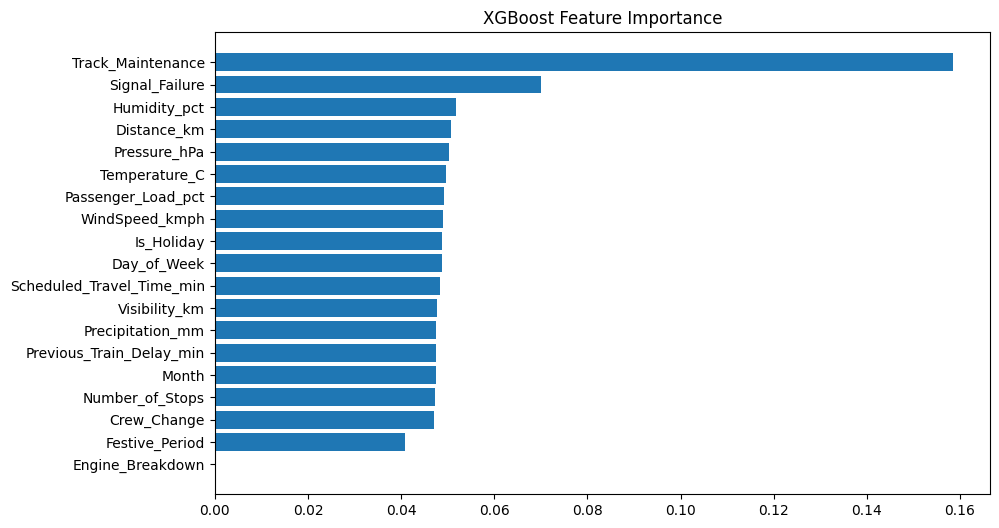

In [112]:
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.show()

feat_imp.head(20)
feat_imp.to_csv("XGBOOSTER DATA.csv", index=False)



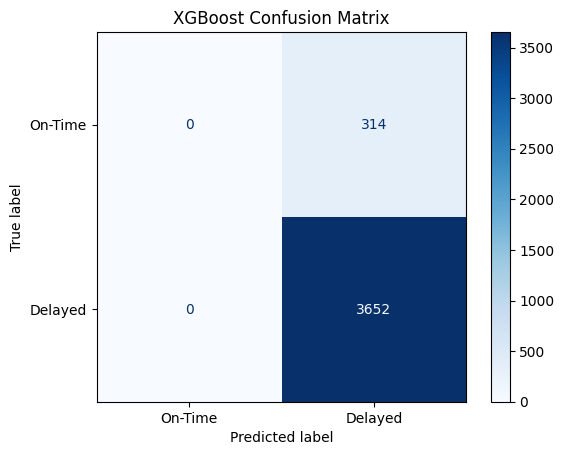

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On-Time", "Delayed"])
disp.plot(cmap="Blues")

plt.title("XGBoost Confusion Matrix")
plt.show()

SPEED AFFECTING FACTORS

In [114]:
from xgboost import XGBRegressor

df["speed_diff"] = df["actual_avg_speed"] - df["est_avg_speed"]

In [129]:
Features = [
    'Distance_km','Scheduled_Travel_Time_min','Day_of_Week','Month',
    'Is_Holiday','Festive_Period','Temperature_C','Humidity_pct',
    'Precipitation_mm','WindSpeed_kmph','Visibility_km','Pressure_hPa',
    'Track_Maintenance','Signal_Failure','Engine_Breakdown',
    'Previous_Train_Delay_min','Number_of_Stops','Crew_Change',
    'Passenger_Load_pct'
]
Z = df[features]
t = df["Delay_Class"]

In [116]:
Z_train, Z_test, t_train, t_test = train_test_split(
    Z, t, test_size=0.2, random_state=42
)

In [117]:
# Convert Humidity_pct to numeric if it's not already
for df_ in [Z_train, Z_test]:
    df_["Humidity_pct"] = pd.to_numeric(df_["Humidity_pct"], errors="coerce")

# Encode categorical columns
cat_cols_diff = Z_train.select_dtypes(include='object').columns
le_diff_dict = {}
for col in cat_cols_diff:
    le = LabelEncoder()
    Z_train[col] = le.fit_transform(Z_train[col].astype(str))
    Z_test[col] = le.transform(Z_test[col].astype(str))
    le_diff_dict[col] = le

model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model.fit(Z_train, t_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [118]:
t_pred = model.predict(Z_test)

In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(t_test, t_pred))
mae = mean_absolute_error(t_test, t_pred)
r2 = r2_score(t_test, t_pred)

print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)

RMSE: 0.27449178443489325
MAE : 0.14596162736415863
R²  : -0.03348374366760254


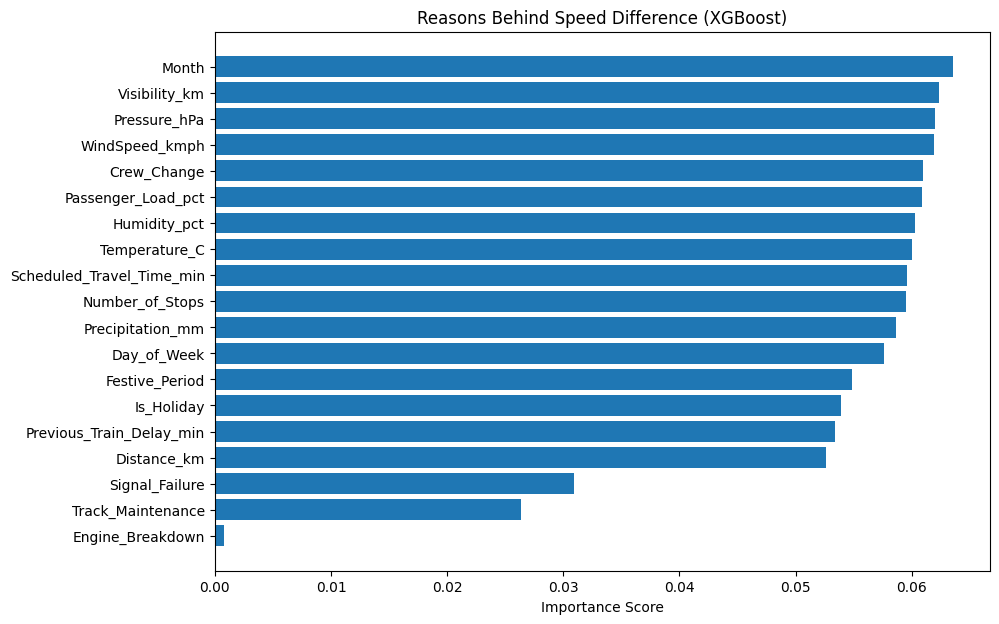

In [130]:
importances = model.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": Z.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,7))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.title("Reasons Behind Speed Difference (XGBoost)")
plt.xlabel("Importance Score")
plt.show()
feat_imp.to_csv("speed-dif.csv")

WEATHER AFFECTING FACTORS


                  Precipitation_mm  Humidity_pct  Temperature_C
WeatherCondition                                               
Clear                     0.317262     53.519622      25.191903
Clouds                    0.875540     53.635584      25.167234
Fog                       0.034549     53.609646      25.198598
Haze                      0.323511     52.650270      24.800358
Rain                     12.427681     69.278883      28.239890
Thunderstorm             85.535455     68.542216      28.465537


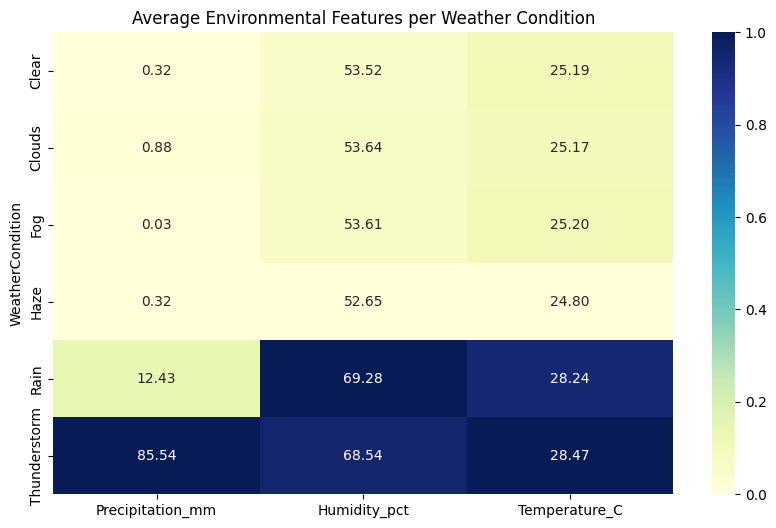

In [125]:

df['Humidity_pct'] = pd.to_numeric(df['Humidity_pct'], errors='coerce')

df = df.dropna(subset=['WeatherCondition', 'Precipitation_mm', 'Humidity_pct', 'Temperature_C'])


weather_stats = df.groupby('WeatherCondition')[['Precipitation_mm', 'Humidity_pct', 'Temperature_C']].mean()


weather_stats_norm = (weather_stats - weather_stats.min()) / (weather_stats.max() - weather_stats.min())


plt.figure(figsize=(10, 6))
sns.heatmap(weather_stats_norm, annot=weather_stats, fmt=".2f", cmap='YlGnBu')
plt.title('Average Environmental Features per Weather Condition')
plt.savefig('weather_heatmap.png')

print(weather_stats)
weather_stats.to_csv("heat_map.csv")
